In [31]:
import torch
import sys
sys.path.append('..')
from models.resnet import resnet32
model = resnet32(100)

abd_path= '/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/cifar100/DFCIL-tentask/CIFAR100/abd/models/repeat-1/task-10/class.pth'
model.load_state_dict(torch.load(abd_path))

abd_weight_norm=torch.cat([model.last.weight.data, model.last.bias.data.view(-1, 1)], dim=1).norm(dim=1)

# print(model.named_modules())

deepinv_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/cifar100/DFCIL-tentask/CIFAR100/deepinv/models/repeat-1/task-10/class.pth'
model.load_state_dict(torch.load(deepinv_path))

deepinv_weight_norm=torch.cat([model.last.weight.data, model.last.bias.data.view(-1, 1)], dim=1).norm(dim=1)

lwf_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/cifar100/DFCIL-tentask/CIFAR100/lwf/models/repeat-1/task-10/class.pth'
model.load_state_dict(torch.load(lwf_path))

lwf_weight_norm=torch.cat([model.last.weight.data, model.last.bias.data.view(-1, 1)], dim=1).norm(dim=1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/cifar100/DFCIL-tentask/CIFAR100/abd/models/repeat-1/task-10/class.pth'

In [11]:
# load rdfcil implementation's class norm
import pandas as pd
from cl_lite.backbone.resnet_cifar import CifarResNet

import sys
sys.path.append('..')
from rdfcil.datamodule import DataModule
from cl_lite.head import DynamicSimpleHead
class_order=[23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]
num_tasks=5
num_classes=100
t=num_tasks
class ISCF_ResNet(CifarResNet):
    def __init__(self, n=5, nf=16, channels=3, preact=False, zero_residual=True, pooling_config=..., downsampling="stride", final_layer=False, all_attentions=False, last_relu=False, **kwargs):
        super().__init__(n, nf, channels, preact, zero_residual, pooling_config, downsampling, final_layer, all_attentions, last_relu, **kwargs)        
    def forward_feat(self, x):
        x = self.conv_1_3x3(x)
        x = F.relu(self.bn_1(x), inplace=True)

        feats_s1, x1 = self.stage_1(x)
        feats_s2, x2 = self.stage_2(x1)
        feats_s3, x3 = self.stage_3(x2)
        x4 = self.stage_4(x3)

        return x4,[x1, x2, x3]


# dataload
data_module = DataModule(root='/data', 
                        dataset='cifar100', 
                        batch_size=128, 
                        num_workers=4,
                        num_tasks=num_tasks,
                        class_order=class_order,
                        current_task=t-1,
                        )
data_module.setup()
backbone = ISCF_ResNet()
head = DynamicSimpleHead(num_classes=data_module.num_classes, num_features=backbone.num_features, bias=False)
# head = DynamicSimpleHead(num_classes=data_module.num_classes, num_features=backbone.num_features, bias=True)


rdfcil_path = '/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/rdfcil/lightning_logs/ijcv/version_828_rdfcil_10task_cifar100_42.01/task_9/checkpoints/best_acc.ckpt'
ours_path = '/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/rdfcil/lightning_logs/ijcv/version_816_cifar_10t_43.57/task_9/checkpoints/best_acc.ckpt'

state_dict = torch.load(rdfcil_path)['state_dict']
backbone_state= {}
head_state = {}
for _ in range(t-1):
    head.append(num_classes//num_tasks)
for k,v in state_dict.items():
    if k.startswith('backbone'):
        backbone_state[k[9:]] = v
    elif k.startswith('head'):
        head_state[k[5:]] = v
        # head_state[k[17:]] = v
        
    
backbone.load_state_dict(backbone_state)
backbone.eval()
head.load_state_dict(head_state)
    
ours_class_norm = head.embeddings.norm(dim=1)
torch.save(ours_class_norm,'rdfcil_5t_cifar_class_norm.pth')


Files already downloaded and verified
Files already downloaded and verified
[23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]


In [16]:
ours_class_norm = torch.load('ours_5t_cifar_class_norm.pth').detach()
rdfcil_class_norm = torch.load('rdfcil_5t_cifar_class_norm.pth').detach()

In [24]:
head = DynamicSimpleHead(num_classes=20, num_features=64, bias=False)
rdfcil_head_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/rdfcil_head_4task_beforeft.pth'
rdfcil_head_before_ft=torch.load(rdfcil_head_path)

print(rdfcil_head_before_ft.shape)
rdfcil_class_norm_before_ft = rdfcil_head_before_ft.norm(dim=1).cpu().detach()


torch.Size([100, 64])


torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


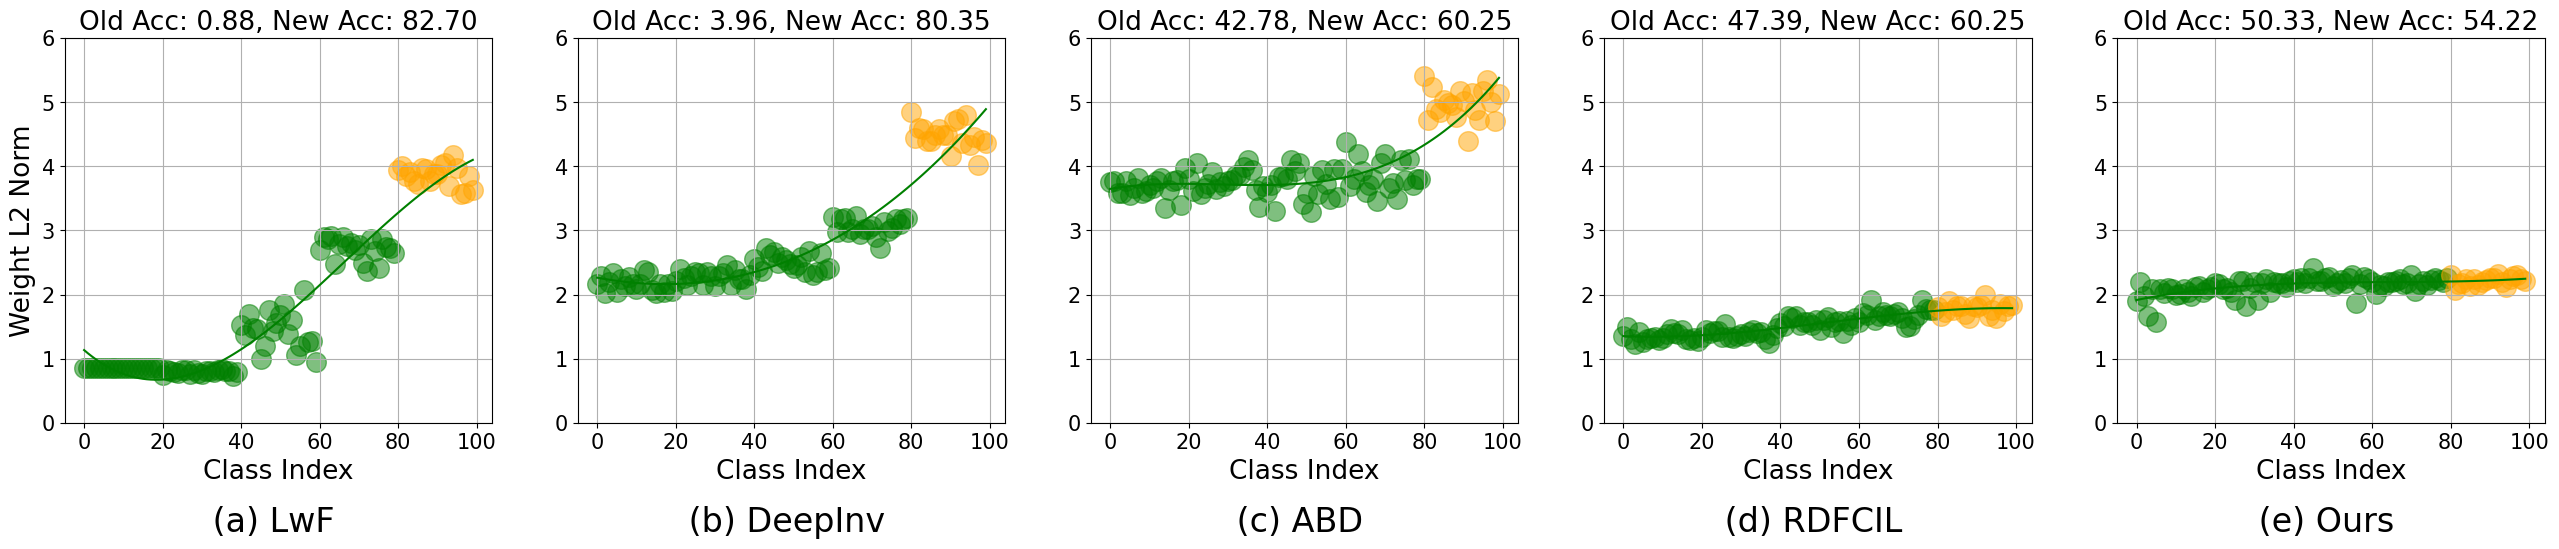

In [82]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure with subplots
fig, ax = plt.subplots(1, 5, figsize=(32, 5))
# fig, ax = plt.subplots(1, 6, figsize=(27, 5))
class_idx = np.arange(100)

# weight_norms = [lwf_weight_norm,deepinv_weight_norm, abd_weight_norm, rdfcil_class_norm, rdfcil_class_norm_before_ft, ours_class_norm]
# names=['LwF','DeepInv', 'ABD', 'RDFCIL', 'RDFCIL-ft', 'Ours']
olds = [ 0.875, 3.9625, 42.78, 47.39, 50.33]
news = [ 82.7, 80.35 ,60.25, 60.25, 54.22]
weight_norms = [lwf_weight_norm,deepinv_weight_norm, abd_weight_norm, rdfcil_class_norm, ours_class_norm]
names=['LwF','DeepInv', 'ABD', 'RDFCIL',  'Ours']
# Scatter plot for all the class norms
alphabet=['a','b','c','d','e']
for i, weight_norm in enumerate(weight_norms):
    print(weight_norm.shape)
    ax[i].scatter(class_idx[:80], weight_norm[:80], label='Class Norm (0-79)', color='green', alpha=0.5, s=200)
    ax[i].scatter(class_idx[80:], weight_norm[80:], label='Class Norm (80-99)', color='orange', alpha=0.5, s=200)
    trendline = np.polyfit(class_idx, weight_norm, deg=3)
    ax[i].plot(class_idx, np.polyval(trendline, class_idx), color='green', label='Trendline')
    ax[i].set_xlabel('Class Index',fontsize=19)
    # ax[i].set_xlabel('Class Index \n\n ({}) {}'.format(alphabet[i],names[i]),fontsize=19)
    if i==0:
        ax[i].set_ylabel('Weight L2 Norm',fontsize=19)
    ax[i].legend().set_visible(False)
    ax[i].set_ylim(0,6)
    ax[i].set_title('Old Acc: {:.2f}, New Acc: {:.2f}'.format(olds[i],news[i]),fontsize=19)
    # ax[i].set_title(names[i]+' (Std: {:.3f})'.format(weight_norm.std()))
    ax[i].grid()
    
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    ax[i].text(47,-1.7,' ({}) {}'.format(alphabet[i],names[i]),fontsize=24,horizontalalignment='center')

plt.savefig('weight_norm_cifar100.pdf',bbox_inches='tight')
